In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import dgl
import scipy.sparse as sp

/home/mjyin/miniconda3/envs/recbole-cdr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from recbole_cdr.quick_start import load_data_and_model
debug = 'recbole-cdr-ckpt/MacridDAE30-Jul-31-2023_14-47-04.739456.pth'
config, model, dataset, train_data, valid_data, test_data, trainer = load_data_and_model(debug)
model.eval()
print(model.mask_source.weight)
print(model.mask_target.weight)

31 Jul 14:50    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2023
state = INFO
reproducibility = True
data_path = dataset/
checkpoint_dir = recbole-cdr-ckpt
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
train_batch_size = 512
learner = adam
learning_rate = 0.001
neg_sampling = {'uniform': 1}
eval_step = 1
stopping_step = 20
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4
epochs = 1000

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'split_valid': {'RS': [0.8, 0.2]}, 'group_by': 'user', 'order': 'RO', 'mode': 'full'}
repeatable = False
metrics = ['Recall', 'NDCG']
topk = [20]
valid_metric = NDCG@20
valid_metric_bigger = True
eval_batch_size = 4096000
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = ,
source_domain = {'dataset': 'epinions-electronic', 'data_path': 'dataset/epinions-e

Parameter containing:
tensor([[0.7970, 0.2020, 0.0018, 1.1617]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.2294,  0.6241,  0.0149, -0.1736]], device='cuda:0',
       requires_grad=True)


In [3]:
trainer.model.set_full_sort_func('Source')
trainer.model.set_predict_func('Source')
source_user_count = train_data.dataset.source_domain_dataset.user_counter
test_result_source = trainer.evaluate(test_data[0], load_best_model=False, show_progress=config['show_progress'], analyze=True, user_count=source_user_count)

Evaluate   :   0%|                                                           | 0/20 [00:00<?, ?it/s]:   0%|                                 | 0/20 [00:27<?, ?it/s, GPU RAM: 16.10 G/79.21 G]:   5%|█▎                       | 1/20 [00:27<08:51, 27.99s/it, GPU RAM: 16.10 G/79.21 G]:   5%|█▎                       | 1/20 [00:28<08:51, 27.99s/it, GPU RAM: 16.10 G/79.21 G]:   5%|█▎                       | 1/20 [00:28<08:51, 27.99s/it, GPU RAM: 16.10 G/79.21 G]:  15%|███▊                     | 3/20 [00:28<02:04,  7.31s/it, GPU RAM: 16.10 G/79.21 G]:  15%|███▊                     | 3/20 [00:28<02:04,  7.31s/it, GPU RAM: 16.10 G/79.21 G]:  15%|███▊                     | 3/20 [00:28<02:04,  7.31s/it, GPU RAM: 16.10 G/79.21 G]:  25%|██████▎                  | 5/20 [00:28<00:53,  3.58s/it, GPU RAM: 16.10 G/79.21 G]:  25%|██████▎                  | 5/20 [00:28<00:53,  3.58s/it, GPU RAM: 16.10 G/79.21 G]:  25%|██████▎                  | 5/20 [00:28<00:53,  3.58s/it, GPU RAM: 16.10 G/79.21 G]:  25%|███

group 0 len 4538--- recall@20:nan   ndcg@20:0.0009755713890496389
group 1 len 616--- recall@20:nan   ndcg@20:0.0
group 2 len 554--- recall@20:nan   ndcg@20:0.0023085612737385017
group 3 len 314--- recall@20:nan   ndcg@20:0.0


In [4]:
import numpy as np
from sklearn.manifold import TSNE
# h_original = torch.load('./debug1.pth', map_location='cpu').detach()
h_original = torch.load('./4factor_cov_reg.pth', map_location='cpu').detach()
# h_original = torch.stack(trainer.model.debug_list, dim=0).detach().cpu()
# h_original = torch.stack(trainer.model.h_source_list, dim=0).detach().cpu()
# num_sampling = torch.randint(1, h.shape[1], (1000, 1)).squeeze()
# h = h[:, num_sampling]
print(h_original.shape)


torch.Size([4, 13842, 64])


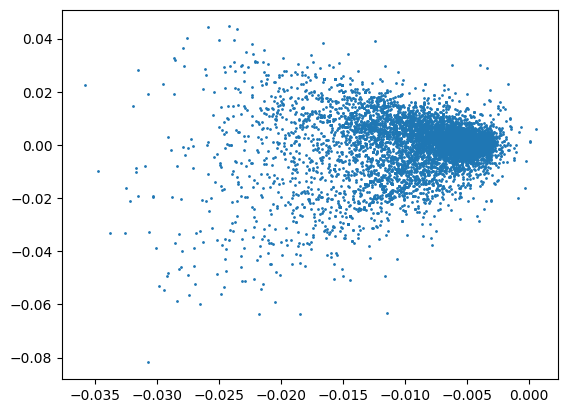

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
# ax1.set_xlim(-0.042, 0.042)
# ax1.set_ylim(-0.042, 0.042)
h = h_original[2]
U, S, V = torch.svd_lowrank(h, 2)
h = U.detach()
plt.scatter(h[:, 0], h[:, 1], s=1)
plt.show()

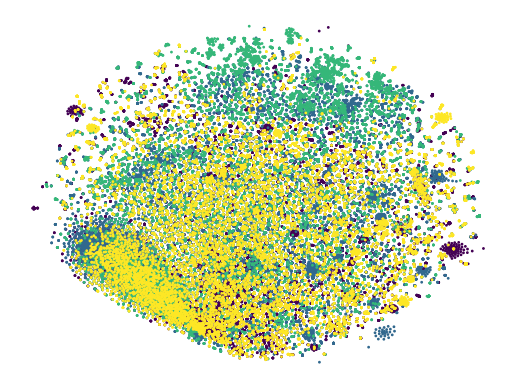

In [6]:
h = h_original
color = torch.arange(h.shape[0]).repeat_interleave(h.shape[1])
# color = torch.arange(h.shape[1]).repeat(h.shape[0])
X = h.flatten(0, 1)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=20).fit_transform(X)
import matplotlib.pyplot as plt
fig = plt.figure()
myfig = plt.gcf()
plt.axis('off')
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color, s=1)

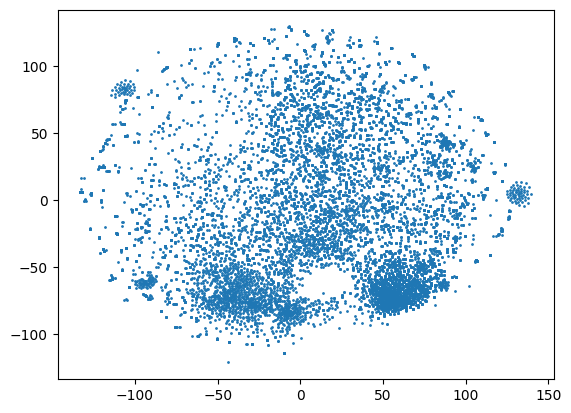

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
myfig = plt.gcf()
# plt.axis('off')
data = np.split(X_embedded, 4, axis=0)
plt.scatter(data[0][:, 0], data[0][:, 1], s=1)

In [ ]:
import seaborn as sns
S0 = F.normalize(h[0][:50]) @ F.normalize(h[0][:50]).T
S1 = F.normalize(h[2][:50]) @ F.normalize(h[2][:50]).T
sns.heatmap(S0)

In [ ]:
sns.heatmap(S1)